# Simple

A replica of the C++ version to be found in ../src/roq/samples/simple/

In [1]:
import logging

In [2]:
# Do NOT enable logging unless you REALLY need it! And then DO NOT SAVE this workbook!
# logging.basicConfig(level=logging.INFO)

In [3]:
import datetime

In [4]:
%matplotlib inline

## Import the Roq Python wrapper

### Note!

You will have to follow these steps before launching Jupyter

* Install Miniconda from https://docs.conda.io/en/latest/miniconda.html
    * `wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh`
    * `bash Miniconda3-latest-Linux-x86_64.sh -b`
    * `source ~/miniconda3/bin/activate'
* Install the Roq Python package from https://roq-trading.com/conda/unstable
    * `conda install --override-channels --channel defaults --channel https://roq-trading.com/conda/unstable roq-python`

In [5]:
import roq

## The event handler interface: roq.client.Handler

In [6]:
help(roq.client.Handler)

Help on class Handler in module roq.client:

class Handler(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      Handler
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(...)
 |      __init__(self: roq.client.Handler) -> None
 |  
 |  cancel_order(...)
 |      cancel_order(self: roq.client.Handler, account: str, order_id: int, source: int) -> None
 |  
 |  create_order(...)
 |      create_order(self: roq.client.Handler, account: str, order_id: int, exchange: str, symbol: str, side: roq.Side, quantity: float, order_type: roq.OrderType, limit_price: float, time_in_force: roq.TimeInForce, position_effect: roq.PositionEffect, order_template: str, source: int) -> None
 |  
 |  modify_order(...)
 |      modify_order(self: roq.client.Handler, account: str, order_id: int, quantity_change: float, limit_price: float, source: int) -> None
 |  
 |  on_cancel_order_ack(...)
 |      on_cancel_order_ack(self: roq.clie

## A trivial implementation of the event handler interface

Enable logging (see above) if you want to see each event.

In [7]:
class Strategy(roq.client.Handler):
    """
    A simple strategy implementing the client interface.
    """

    def __init__(
            self,
            account: str,
            exchange: str,
            symbol: str):
        """
        Constructor
        """
        roq.client.Handler.__init__(self)  # important! see pybind11 doc
        self.account = account
        self.exchange = exchange
        self.symbol = symbol

    def on_start(self):
        """ Event handler """
        logging.info('on_start()')

    def on_stop(self):
        """ Event handler """
        logging.info('on_stop()')

    def on_connection_status(
            self,
            source: int,
            source_name: str,
            connection_status: roq.ConnectionStatus):
        """ Event handler """
        logging.info(
            'on_connection_status(' \
                    'source=%d source_name=%s connection_status=%s)',
            source,
            source_name,
            connection_status)
        if connection_status == roq.ConnectionStatus.CONNECTED:
            self.subscribe(
                accounts={
                    'A1'
                },
                symbols_by_exchange={
                    self.exchange: {
                        self.symbol
                    }
                },
                source=source)

    def on_batch_begin(
            self,
            message_info: roq.MessageInfo):
        """ Event handler """
        logging.info(
            'on_batch_begin(message_info=%s)',
            message_info)

    def on_batch_end(
            self,
            message_info: roq.MessageInfo):
        """ Event handler """
        logging.info(
            'on_batch_end(message_info=%s)',
            message_info)

    def on_market_data_status(
            self,
            message_info: roq.MessageInfo,
            market_data_status: roq.MarketDataStatus):
        """ Event handler """
        logging.info(
            'on_market_data_status(' \
                    'message_info=%s market_data_status=%s)',
            message_info,
            market_data_status)

    def on_order_manager_status(
            self,
            message_info: roq.MessageInfo,
            order_manager_status: roq.OrderManagerStatus):
        """ Event handler """
        logging.info(
            'on_order_manager_status(' \
                    'message_info=%s order_manager_status=%s)',
            message_info,
            order_manager_status)

    def on_download_begin(
            self,
            message_info: roq.MessageInfo,
            download_begin: roq.DownloadBegin):
        """ Event handler """
        logging.info(
            'on_download_begin(message_info=%s download_begin=%s)',
            message_info,
            download_begin)

    def on_download_end(
            self,
            message_info: roq.MessageInfo,
            download_end: roq.DownloadEnd):
        """ Event handler """
        logging.info(
            'on_download_end(message_info=%s download_end=%s)',
            message_info,
            download_end)

    def on_reference_data(
            self,
            message_info: roq.MessageInfo,
            reference_data: roq.ReferenceData):
        """ Event handler """
        logging.info(
            'on_reference_data(message_info=%s reference_data=%s)',
            message_info,
            reference_data)

    def on_market_status(
            self,
            message_info: roq.MessageInfo,
            market_status: roq.MarketStatus):
        """ Event handler """
        logging.info(
            'on_market_status(message_info=%s market_status=%s)',
            message_info,
            market_status)

    def on_session_statistics(
            self,
            message_info: roq.MessageInfo,
            session_statistics: roq.SessionStatistics):
        """ Event handler """
        logging.info(
            'on_session_statistics(' \
                    'message_info=%s session_statistics=%s)',
            message_info,
            session_statistics)

    def on_daily_statistics(
            self,
            message_info: roq.MessageInfo,
            daily_statistics: roq.DailyStatistics):
        """ Event handler """
        logging.info(
            'on_daily_statistics(message_info=%s daily_statistics=%s)',
            message_info,
            daily_statistics)

    # on_market_by_price

    def on_trade_summary(
            self,
            message_info: roq.MessageInfo,
            trade_summary: roq.TradeSummary):
        """ Event handler """
        logging.info(
            'on_trade_summary(message_info=%s trade_summary=%s)',
            message_info,
            trade_summary)

    def on_position_update(
            self,
            message_info: roq.MessageInfo,
            position_update: roq.PositionUpdate):
        """ Event handler """
        logging.info(
            'on_position_update(message_info=%s position_update=%s)',
            message_info,
            position_update)

    def on_order_update(
            self,
            message_info: roq.MessageInfo,
            order_update: roq.OrderUpdate):
        """ Event handler """
        logging.info(
            'on_order_update(message_info=%s order_update=%s)',
            message_info,
            order_update)

    def on_trade_update(
            self,
            message_info: roq.MessageInfo,
            trade_update: roq.TradeUpdate):
        """ Event handler """
        logging.info(
            'on_trade_update(message_info=%s trade_update=%s)',
            message_info,
            trade_update)

    def on_create_order_ack(
            self,
            message_info: roq.MessageInfo,
            create_order_ack: roq.CreateOrderAck):
        """ Event handler """
        logging.info(
            'on_create_order_ack(message_info=%s create_order_ack=%s)',
            message_info,
            create_order_ack)

    def on_modify_order_ack(
            self,
            message_info: roq.MessageInfo,
            modify_order_ack: roq.ModifyOrderAck):
        """ Event handler """
        logging.info(
            'on_modify_order_ack(message_info=%s modify_order_ack=%s)',
            message_info,
            modify_order_ack)

    def on_cancel_order_ack(
            self,
            message_info: roq.MessageInfo,
            cancel_order_ack: roq.CancelOrderAck):
        """ Event handler """
        logging.info(
            'on_cancel_order_ack(message_info=%s cancel_order_ack=%s)',
            message_info,
            cancel_order_ack)

## A simple wrapper function so we can time it

In [8]:
def run_simulation(strategy, connections):
    """ Simulation example.
    """
    # creates an event generator object
    generator = roq.client.Simulation.create_generator(type='csv-old', history=connections[0])
    # creates an order matching object
    matcher = roq.client.Simulation.create_matcher(type='simple', name='CFFEX')
    # creates a collector
    collector = roq.client.Simulation.create_collector(period=datetime.timedelta(seconds=1))
    # runs the simulation
    roq.client.Simulation(strategy, generator, matcher, collector).dispatch()
    # done
    return collector

## Variables

In [9]:
ACCOUNT = 'A1'  # not really important unless you switch to trading
EXCHANGE = 'CFFEX'  # China Financial Futures EXchange
SYMBOL = 'IC1803'  # the most liquid instrument (on the specific trading day)

In [10]:
def get_data_path(filename):
    """ Helper function to work out the full path for an installed example dataset.
    """
    import os
    CONDA_DIR = os.environ['CONDA_DIR']
    return os.path.join(CONDA_DIR, *'share/roq/data'.split('/'), filename)

In [11]:
HISTORY = get_data_path('USTP_Multi_20180223.csv')  # about 372k market data events (a full trading day)

## Strategy

In [12]:
STRATEGY = Strategy(account=ACCOUNT, exchange=EXCHANGE, symbol=SYMBOL)

## Run the simulation...

### ... time it

In [13]:
%timeit run_simulation(STRATEGY, [HISTORY,])

2.09 s ± 60.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### ... further analysis

In [14]:
collector = run_simulation(STRATEGY, [HISTORY,])

In [15]:
trade_volume = collector.extract(exchange=EXCHANGE, symbol=SYMBOL, type="trade_volume")
trade_volume.head()

,,volume
time,price,
1519378161000000000,5830.0,20.0
1519378221000000000,5830.0,34.0
1519378222000000000,5830.0,76.0
1519378223000000000,5829.0,83.0
1519378224000000000,5829.2,90.0


In [16]:
market_by_price = collector.extract(exchange=EXCHANGE, symbol=SYMBOL, type="market_by_price")
market_by_price.head(20)

quantity
time                price           
1519378161000000000 5836.0      -1.0
                    5837.8      -1.0
                    5831.0      -1.0
                    5821.2       1.0
                    5825.0       1.0
                    5834.0      -5.0
                    5820.4       1.0
                    5820.0       1.0
                    5819.2       1.0
                    5830.0      -8.0
1519378221000000000 5836.0      -2.0
                    5837.8      -1.0
                    5831.0      -1.0
                    5823.0       5.0
                    5824.0       5.0
                    5829.0       5.0
                    5825.0       6.0
                    5821.2       0.0
                    5834.0      -5.0
                    5820.4       0.0

In [17]:
best_bid_ask = collector.extract(exchange=EXCHANGE, symbol=SYMBOL, type="best_bid_ask")
best_bid_ask.head()

,bid,ask
time,,
1519378161000000000,5825.0,5830.0
1519378221000000000,5830.0,5831.0
1519378222000000000,5829.0,5830.0
1519378223000000000,5829.0,5829.4
1519378224000000000,5829.0,5829.2


### ... some charts

In [18]:
def plot_data(big_size, trade_volume, market_by_price, best_bid_ask):
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(figsize=(16,10))
    tmp = market_by_price.reset_index().pivot(index='time', columns='price', values='quantity')
    ax.pcolor(tmp.index, tmp.columns, tmp.transpose(),
              alpha=0.5, cmap=mpl.cm.get_cmap('PiYG'),
              vmin=-big_size, vmax=big_size)
    best_bid_ask.plot(drawstyle="steps-post", ax=ax)
    trade_volume.reset_index().plot(x='time', y='price',
                                    kind='scatter', marker='.', linewidths=2, edgecolors='black',
                                    ax=ax)
    fig.tight_layout()
    plt.show()

In [19]:
def get_range(df, idx_0, idx_1):
    tmp = df.index.get_level_values(0)[idx_0:idx_1]
    return (tmp[0], tmp[-1])

In [20]:
time_0, time_1 = get_range(trade_volume, 0, 500)
time_0, time_1

(1519378161000000000, 1519378625000000000)

In [21]:
def select_subset(df, time_0, time_1):
    import numpy as np
    include = np.logical_and(
        df.index.get_level_values(0) >= time_0,
        df.index.get_level_values(0) <= time_1)
    return df[include]

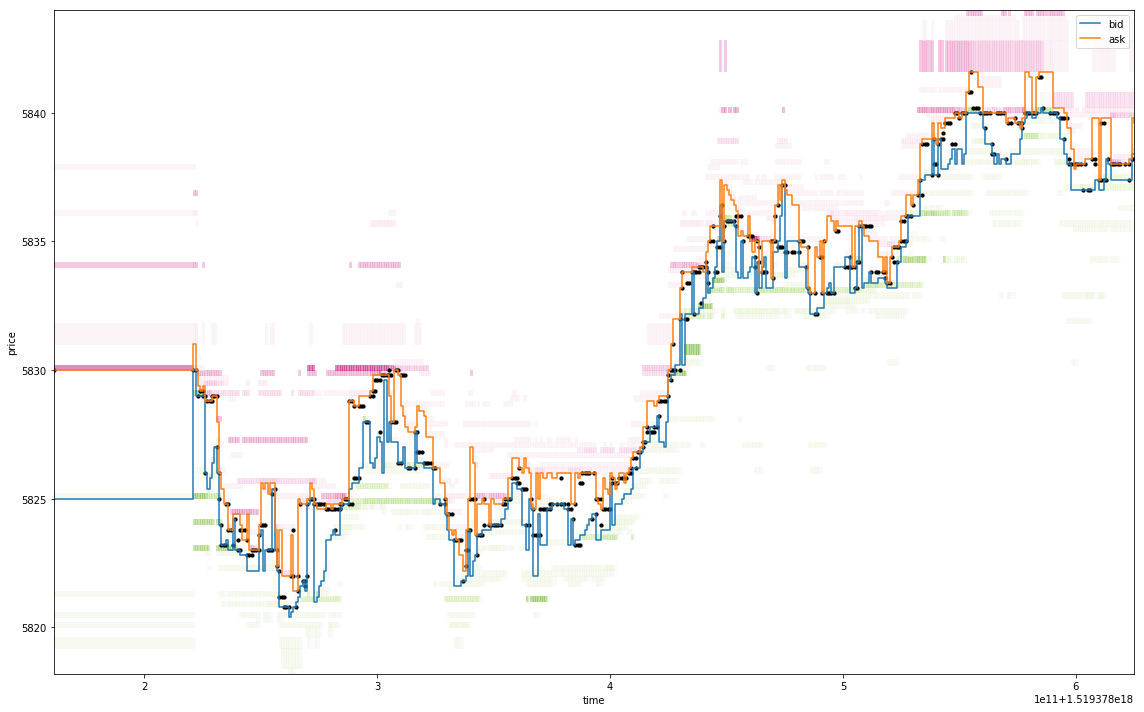

In [22]:
plot_data(
    10,
    select_subset(trade_volume, time_0, time_1),
    select_subset(market_by_price, time_0, time_1),
    select_subset(best_bid_ask, time_0, time_1))